# APIs - Cumulative Lab


## Introduction 

We've seen how the Yelp API works and how to create basic visualizations using Folium. It's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API.

## Objectives

You will be able to: 

* Practice using functions to organize your code
* Use pagination to retrieve all results from an API query
* Practice parsing data returned from an API query
* Practice interpreting visualizations of a dataset
* Create maps using Folium

## Your Task: Query Yelp for All Businesses in a Category and Analyze the Results

![restaurant counter with pizza](images/restaurant_counter.jpg)

Photo by <a href="https://unsplash.com/@jordanmadrid?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jordan Madrid</a> on <a href="/s/photos/pizza-restaurant?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Overview

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. In this lab, you will write a query of businesses on Yelp, then use *pagination* to retrieve all possible results for that query. Then you will create a summary of your findings, including a Folium map of the geographic locations of those businesses.

### Technical Details

Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the **API limits**. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a **maximum of 50 results per request** and defaults to 20. Furthermore, any search will be limited to a **total of 1000 results**. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

Also, be mindful of the **API** ***rate*** **limits**. You can only make **5000 requests per day** and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use `time.sleep(n)` to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a list of dictionaries (for further exploration) and create a map using Folium to visualize the results geographically.

### Requirements

#### 1. Make the Initial Request

Start by filling in your API key to make the initial request to the business search API. Investigate the structure of the response you get back and start figuring out how you will extract the relevant information.

#### 2. Add Pagination

Using loops and functions, collect the maximum number of results for your query from the API.

#### 3. Perform Exploratory Analysis

Interpret visualizations related to the price range, average rating, and number of reviews for all query results.

#### 4. Create a Folium Map

Using latitude and longitude data, plot the query results on an interactive map.

## 1. Make the Initial Request

### Querying

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

Use the `requests` library ([documentation here](https://requests.readthedocs.io/en/master/user/quickstart/#make-a-request)).

You'll also need an API key from Yelp. If you haven't done this already, go to the Yelp [Manage App page](https://www.yelp.com/developers/v3/manage_app) and create a new app (after making an account if you haven't already).

In [68]:
# Replace None with appropriate code

# Import the requests library
import requests
import json

def get_keys(path):
    with open(path) as f:
        return json.load(f)
keys = get_keys("/Users/james/.secret/yelp_api.json")

api_key = keys['api_key']

In [69]:
term = 'Indian'
location = 'London'

# Set up params for request
url = "https://api.yelp.com/v3/businesses/search"
headers = {
    "Authorization": "Bearer {}".format(api_key)
}
url_params = {
    "term": term.replace(" ", "+"),
    "location": location.replace(" ", "+")
}


response = requests.get(url, headers=headers, params=url_params)

# Confirm we got a 200 response
response

<Response [200]>

In [70]:
# Run this cell without changes

# Get the response body in JSON format
response_json = response.json()
# View the keys
response_json.keys()

dict_keys(['businesses', 'total', 'region'])

### Extracting Data

Now, retrieve the value associated with the `'businesses'` key, and inspect its contents.

In [71]:
# Replace None with appropriate code

# Retrieve the value from response_json
businesses = response_json['businesses']

# View the first 2 records
print(len(businesses))

20


### Preparing Data

Write a function `prepare_data` that takes in a list of dictionaries like `businesses` and returns a copy that has been prepared for analysis:

1. The `coordinates` key-value pair has been converted into two separate key-value pairs, `latitude` and `longitude`
2. All other key-value pairs except for `name`, `review_count`, `rating`, and `price` have been dropped
3. All dictionaries missing one of the relevant keys or containing null values have been dropped

In other words, the final keys for each dictionary should be `name`, `review_count`, `rating`, `price`, `latitude`, and `longitude`.

Complete the function in the cell below:

In [72]:
# Replace None with appropriate code

def prepare_data(data_list):
   
    # Make a new list to hold results
    results = []
    
    for business_data in data_list:
        prepared_data = {}
        
        for k in ("name", "review_count", "rating", "price"):
            prepared_data[k] = business_data.get(k, None)

        prepared_data['latitude'] = business_data['coordinates']['latitude']
        prepared_data['longitude'] = business_data['coordinates']['longitude']

        if all(prepared_data.values()):
            results.append(prepared_data)
    
    return results
    
# Test out function
prepared_businesses = prepare_data(businesses)
print(len(prepared_businesses))

16


Check that your function created the correct keys:

In [73]:
# Run this cell without changes

assert sorted(list(prepared_businesses[0].keys())) == ['latitude', 'longitude', 'name', 'price', 'rating', 'review_count']

The following code will differ depending on your query, but we expect there to be 20 businesses in the original list, and potentially fewer in the prepared list (if any of them were missing data):

In [74]:
# Run this cell without changes
print("Original:", len(businesses))
print("Prepared:", len(prepared_businesses))

Original: 20
Prepared: 16


Great! We will reuse this function once we have retrieved the full dataset.

## 2. Add Pagination

Now that you are able to extract information from one page of the response, let's figure out how to request as many pages as possible.

### Determining the Total

Depending on the number of total results for your query, you will either retrieve all of the results, or just the first 1000 (if there are more than 1000 total).

We can find the total number of results using the `"total"` key:

In [75]:
# Run this cell without changes
response_json["total"]

1700

(This is specific to the implementation of the Yelp API. Some APIs will just tell you that there are more pages, or will tell you the number of pages total, rather than the total number of results. If you're not sure, always check the documentation.)

In the cell below, assign the variable `total` to either the value shown above (if it is less than 1000), or 1000.

In [76]:
# Replace None with appropriate code
total = 1000

### Calculating the Offsets

The documentation states in the parameters section:

> **Name**: `limit`, **Type:** int, **Description:** Optional. Number of business results to return. By default, it will return 20. Maximum is 50.

> **Name**: `offset`, **Type:** int, **Description:** Optional. Offset the list of returned business results by this amount.

So, to get the most results with the fewest API calls we want to set a limit of 50 every time. If, say, we wanted to get 210 total results, that would mean:

1. Offset of `0` (first 50 records)
2. Offset of `50` (second 50 records)
3. Offset of `100` (third 50 records)
4. Offset of `150` (fourth 50 records)
5. Offset of `200` (final 10 records)

In the cell below, create a function `get_offsets` that takes in a total and returns a list of offsets for that total. You can assume that there is a limit of 50 every time.

*Hint: you can use `range` ([documentation here](https://docs.python.org/3.3/library/stdtypes.html?highlight=range#range)) to do this in one line of code. Just make the returned result is a list.*

In [77]:
# Replace None with appropriate code
def get_offsets(total):
    return list(range(0, total, 50))

Check that your function works below:

In [78]:
# Run this cell without changes

assert get_offsets(200) == [0, 50, 100, 150]
assert get_offsets(210) == [0, 50, 100, 150, 200]

### Putting It All Together

Recall that the following variable has already been declared for you:

In [79]:
# Run this cell without changes
url_params

{'term': 'Indian', 'location': 'London'}

We'll go ahead and also specify that the limit should be 50 every time:

In [80]:
# Run this cell without changes
url_params["limit"] = 50

In order to modify the offset, you'll need to add it to `url_params` with the key `"offset"` and whatever value is needed.

In the cell below, write code that:

* Creates an empty list for the full prepared dataset
* Loops over all of the offsets from `get_offsets` and makes an API call each time with the specified offset
* Calls `prepare_data` to get a cleaned version of the result of each API call
* Extends the full prepared dataset list with each query's prepared dataset

In [82]:
full_dataset = []

for offset in get_offsets(total):
    url_params["offset"] = offset
    
    response = requests.get(url, headers=headers, params=url_params)
    
    # Get the response body in JSON format
    response_json = response.json()
    
    # Get the list of businesses from the response_json
    businesses = response_json['businesses']
    
    # Call the prepare_data function to get a list of processed data
    prepared_businesses = prepare_data(businesses)
    
    # Extend full_dataset with this list (don't append, or you'll get
    # a list of lists instead of a flat list)
    full_dataset.extend(prepared_businesses)

# Check the length of the full dataset. It will be up to `total`,
# potentially less if there were missing values
len(full_dataset)


671

This code may take up to a few minutes to run.

If you get an error trying to get the response body in JSON format, try adding `time.sleep(1)` right after the `requests.get` line, so your code will sleep for 1 second between each API call.

## 3. Perform Exploratory Analysis

Take the businesses from the previous question and do an initial exploratory analysis. We have provided some plots for you to interpret:

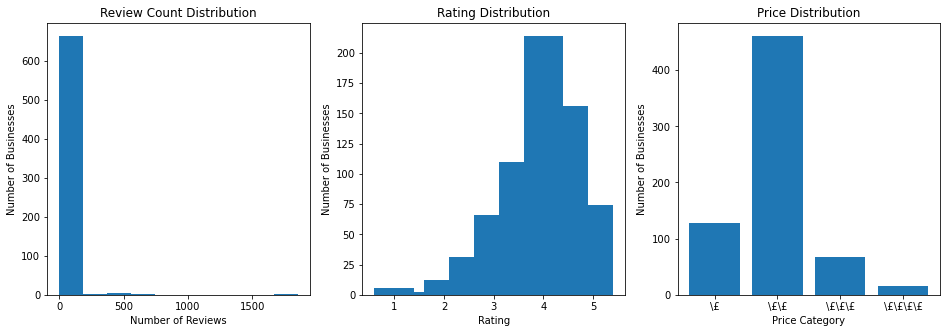

In [83]:
# Run this cell without changes
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5))

# Plot distribution of number of reviews
all_review_counts = [x["review_count"] for x in full_dataset]
ax1.hist(all_review_counts)
ax1.set_title("Review Count Distribution")
ax1.set_xlabel("Number of Reviews")
ax1.set_ylabel("Number of Businesses")

# Plot rating distribution
all_ratings = [x["rating"] for x in full_dataset]
rating_counter = Counter(all_ratings)
rating_keys = sorted(rating_counter.keys())
ax2.bar(rating_keys, [rating_counter[key] for key in rating_keys])
ax2.set_title("Rating Distribution")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Number of Businesses")

# Plot price distribution
all_prices = [x["price"].replace("£", r"\£") for x in full_dataset]
price_counter = Counter(all_prices)
price_keys = sorted(price_counter.keys())
ax3.bar(price_keys, [price_counter[key] for key in price_keys])
ax3.set_title("Price Distribution")
ax3.set_xlabel("Price Category")
ax3.set_ylabel("Number of Businesses");

Describe the distributions displayed above and interpret them in the context of your query. (Your answer may differ from the solution branch depending on your query.)

The review count distribution is massively skewed by the outlier with 1800 reviews, it is worth replotting without the outlier to get more detail on the other places.

The rating distribution is skewed left, with most places getting between 3.5 and 5 ratings. Fewer than 20 places receive less than 2 stars, with 4 stars the most common review, followed by 4.5

The price distribution is skewed towards cheaper places, which isn't a huge surprise given Indian food's mass appeal in the UK ans most Indian restaurants are high street establishments.

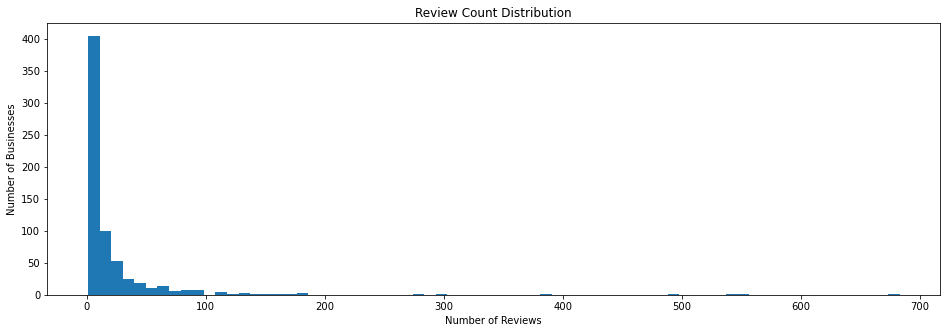

In [98]:
outlier = max(all_review_counts)
norm_review_counts = all_review_counts
norm_review_counts.remove(outlier)

fig, ax = plt.subplots(figsize=(16, 5))
all_review_counts = [x["review_count"] for x in full_dataset]
ax.hist(norm_review_counts, bins=70)
ax.set_title("Review Count Distribution")
ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Number of Businesses");

Now we can see the distribution in more detail, it is still very right skewed, with the vast majority of businesses receiving fewer than 10 reviews, and very few receiving over 100. There are around 6 restaurants that have more than 200 reviews, which maybe worth finding. 

In [100]:
busy_list = []
a=0
for x in all_review_counts:
    if x > 200:
        busy_list.append(a)
    a+=1

names = [z["name"] for z in full_dataset]
latitude = [y["latitude"] for y in full_dataset]

for g in busy_list:
    print(names[g], all_review_counts[g], latitude[g])

Dishoom 1855 51.512447030091
Punjab Restaurant 540 51.514992
Tayyabs 683 51.5172233660434
Dishoom 551 51.513087
Roti Chai 295 51.5146226
Dishoom 495 51.5245310066818
Dishoom 385 51.5363182978271
Mildreds 280 51.5130233764648


https://www.dishoom.com/

we can see that the Dishoom chain is very popular!
    

In the cell below, we also plot the rating distributions by price. In this setup, a price of one dollar sign is "lower price" and everything else is "higher price".

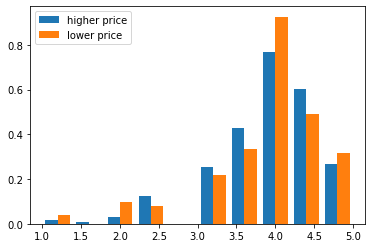

In [101]:
# Run this cell without changes

higher_price = []
lower_price = []
for row in full_dataset:
    if row["price"] == "£":
        lower_price.append(row["rating"])
    else:
        higher_price.append(row["rating"])
        
fig, ax = plt.subplots()

ax.hist([higher_price, lower_price], label=["higher price", "lower price"], density=True)

ax.legend();

Is a higher price associated with a higher rating? (No need for any additional math/statistics, just interpret what you see in the plot.)

The results are quite surprising, with lower price places performing slightly better on 5 scores and substantially better on 4 scores, with the more expensive restaurants performing only slightly better on 4.5 scores.
The lower ratings are fairly evenly spread between the two.
Perhaps the price is built in to the rating, with people marking places more highly
if they think they are getting value for money. Also possible that it is a quirk
of Indian restaurants, with people in the UK traditionally expecting a lot of 
flavour for low price.

Finally, let's look at ratings vs. review counts:

1855


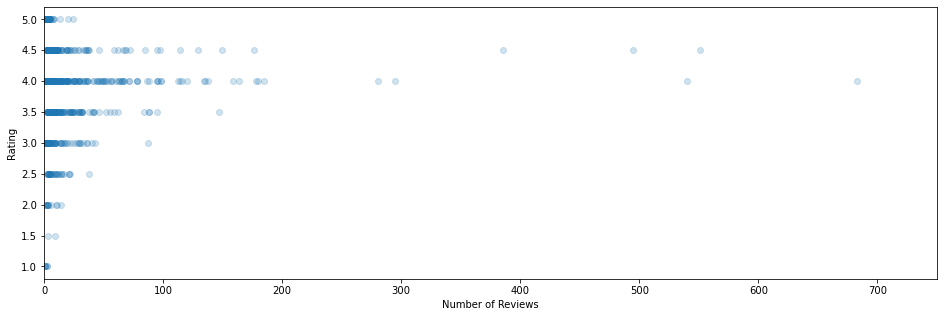

In [102]:
# Run this cell without changes
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(all_review_counts, all_ratings, alpha=0.2)
print(max(all_review_counts))
ax.set_xlabel("Number of Reviews")
ax.set_ylabel("Rating")
# "zoom in" to a subset of review counts
ax.set_xlim(left=0, right=750);

Is a higher number of reviews associated with a higher rating?

It's difficult to say that higher ratings are associated with higher number of reviews as all the 5 star places have fewer than 50 reviews, but the places with large number of reviews all have 4 or 4.5 star ratings and lower rated places also have few reviews. If anything, it seems peak ratings are slightly more strongly associated with number of reviews, but more analysis would be needed to show that.  


## 4. Create a Folium Map

Make a map using Folium of the businesses you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

You can center the map around the latitude and longitude of the first item in `full_dataset`.

In [103]:
import folium


center_lat = 51.51
center_long = -0.14

# Initialize map with center lat and long
yelp_map = folium.Map([center_lat, center_long])

# Adjust this limit to see more or fewer businesses
limit=100

for business in full_dataset[:limit]:
    lat = business['latitude']
    long = business['longitude']
    name = business['name']
    rating = business['rating']
    price = business['price']
    details = "{} Price: {} Rating:{}".format(name,price,rating)
    
    # Create popup with relevant details
    popup = folium.Popup(details, parse_html=True)
    
    # Create marker with relevant lat/long and popup
    marker = folium.Marker(location=[lat, long], popup=popup)
    
    marker.add_to(yelp_map)
    
yelp_map

## Summary

Nice work! In this lab, you've made multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice interactive map to display the results using Folium! Well done!